<a href="https://colab.research.google.com/github/LanguageExchanger/Regression/blob/main/Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Regression

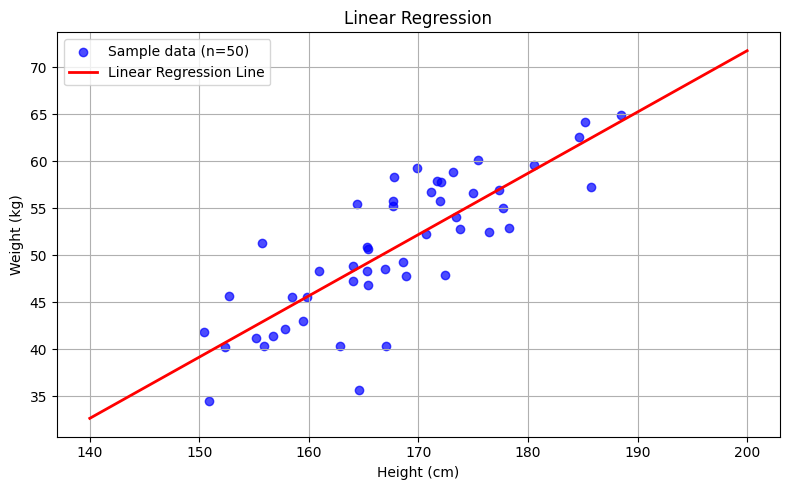

In [ ]:
# 샘플 수를 50개로 증가시켜 키와 몸무게 데이터를 생성 (일상적인 통계 기반 추정)
np.random.seed(42)
heights_50 = np.random.normal(loc=170, scale=10, size=50).reshape(-1, 1)  # 평균 170, 표준편차 10
weights_50 = 0.6 * heights_50.flatten() - 50 + np.random.normal(0, 5, size=50)  # 대략적인 관계식 + 노이즈

# 선형 회귀 모델 학습
model_50 = LinearRegression()
model_50.fit(heights_50, weights_50)

# 예측선
x_range_50 = np.linspace(140, 200, 200).reshape(-1, 1)
y_pred_50 = model_50.predict(x_range_50)

# 그래프 시각화
plt.figure(figsize=(8, 5))
plt.scatter(heights_50, weights_50, color='blue', alpha=0.7, label='Sample data (n=50)')
plt.plot(x_range_50, y_pred_50, color='red', linewidth=2, label='Linear Regression Line')
plt.title('Linear Regression')
plt.xlabel('Height (cm)')
plt.ylabel('Weight (kg)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## boston data preparation

In [ ]:
from sklearn.datasets import fetch_openml
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

boston = fetch_openml(name='boston')
bostonDF = pd.DataFrame(boston.data , columns = boston.feature_names)

bostonDF['RAD'] = pd.to_numeric(bostonDF['RAD'], errors='coerce')
bostonDF['CHAS'] = pd.to_numeric(bostonDF['CHAS'], errors='coerce')
bostonDF['PRICE'] = boston.target

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'],axis=1,inplace=False)

## Function Defenition

In [ ]:
from sklearn.linear_model import Lasso, ElasticNet

# alpha값에 따른 회귀 모델의 폴드 평균 RMSE를 출력하고 회귀 계수값들을 DataFrame으로 반환
def get_linear_reg_eval(model_name, params=None, X_data_n=None, y_target_n=None,
                        verbose=True, return_coeff=True):
    coeff_df = pd.DataFrame()
    if verbose : print('####### ', model_name , '#######')
    for param in params:
        if model_name =='Ridge': model = Ridge(alpha=param)
        elif model_name =='Lasso': model = Lasso(alpha=param)
        elif model_name =='ElasticNet': model = ElasticNet(alpha=param, l1_ratio=0.7)
        neg_mse_scores = cross_val_score(model, X_data_n,
                                             y_target_n, scoring="neg_mean_squared_error", cv = 5)
        avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
        print('alpha {0}일 때 5 폴드 세트의 평균 RMSE: {1:.3f} '.format(param, avg_rmse))
        # cross_val_score는 evaluation metric만 반환하므로 모델을 다시 학습하여 회귀 계수 추출

        model.fit(X_data_n , y_target_n)
        if return_coeff:
            # alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 컬럼으로 추가.
            coeff = pd.Series(data=model.coef_ , index=X_data_n.columns )
            colname='alpha:'+str(param)
            coeff_df[colname] = coeff

    return coeff_df
# end of get_linear_regre_eval

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

# method는 표준 정규 분포 변환(Standard), 최대값/최소값 정규화(MinMax), 로그변환(Log) 결정
# p_degree는 다향식 특성을 추가할 때 적용. p_degree는 2이상 부여하지 않음.
def get_scaled_data(method='None', p_degree=None, input_data=None):
    if method == 'Standard':
        scaled_data = StandardScaler().fit_transform(input_data)
    elif method == 'MinMax':
        scaled_data = MinMaxScaler().fit_transform(input_data)
    elif method == 'Log':
        scaled_data = np.log1p(input_data)
    else:
        scaled_data = input_data

    if p_degree != None:
        scaled_data = PolynomialFeatures(degree=p_degree,
                                         include_bias=False).fit_transform(scaled_data)

    return scaled_data

In [ ]:
# Ridge의 alpha값을 다르게 적용하고 다양한 데이터 변환방법에 따른 RMSE 추출.
alphas = [0.1, 1, 10, 100]
#변환 방법은 모두 6개, 원본 그대로, 표준정규분포, 표준정규분포+다항식 특성
# 최대/최소 정규화, 최대/최소 정규화+다항식 특성, 로그변환
scale_methods=[(None, None), ('Standard', None), ('Standard', 2),
               ('MinMax', None), ('MinMax', 2), ('Log', None)]

for scale_method in scale_methods:
    X_data_scaled = get_scaled_data(method=scale_method[0], p_degree=scale_method[1],
                                    input_data=X_data)
    print(X_data_scaled.shape, X_data.shape)
    print('\n## 변환 유형:{0}, Polynomial Degree:{1}'.format(scale_method[0], scale_method[1]))
    get_linear_reg_eval('Ridge', params=alphas, X_data_n=X_data_scaled,
                        y_target_n=y_target, verbose=False, return_coeff=False)

(506, 13) (506, 13)

## 변환 유형:None, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.788 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.653 
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.518 
alpha 100일 때 5 폴드 세트의 평균 RMSE: 5.330 
(506, 13) (506, 13)

## 변환 유형:Standard, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.826 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.803 
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.637 
alpha 100일 때 5 폴드 세트의 평균 RMSE: 5.421 
(506, 104) (506, 13)

## 변환 유형:Standard, Polynomial Degree:2
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 8.827 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 6.871 
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.485 
alpha 100일 때 5 폴드 세트의 평균 RMSE: 4.634 
(506, 13) (506, 13)

## 변환 유형:MinMax, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.764 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.465 
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.754 
alpha 100일 때 5 폴드 세트의 평균 RMSE: 7.635 
(506, 104) (506, 13)

## 변환 유형:MinMax, Polynomial Degree:2
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.298 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 4.323 
alpha 10일 때 5 폴드 세트의 평균 RMS

# Gradient Descent

실제값을 Y=4X+6 시뮬레이션하는 데이터 값 생성

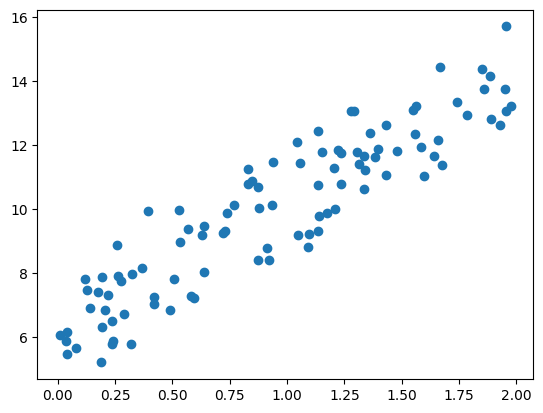

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)
# y = 4X + 6 식을 근사(w1=4, w0=6). random 값은 Noise를 위해 만듬
X = 2 * np.random.rand(100,1)
y = 6 +4 * X+ np.random.randn(100,1)

# X, y 데이터 셋 scatter plot으로 시각화
plt.scatter(X, y)

In [ ]:
X.shape, y.shape

((100, 1), (100, 1))

w0과 w1의 값을 최소화 할 수 있도록 업데이트 수행하는 함수 생성

* 예측 배열 y_pred는 np.dot(X, w1.T) + w0 임 100개의 데이터 X(1,2,...,100)이 있다면 예측값은 w0 + X(1)w1 + X(2)w1 +..+ X(100)*w1이며, 이는 입력 배열 X와 w1 배열의 내적임.

In [ ]:
# w1 과 w0 를 업데이트 할 w1_update, w0_update를 반환.
def get_weight_updates(w1, w0, X, y, learning_rate=0.01):
    N = len(y)
    # 먼저 w1_update, w0_update를 각각 w1, w0의 shape와 동일한 크기를 가진 0 값으로 초기화
    w1_update = np.zeros_like(w1)
    w0_update = np.zeros_like(w0)
    # 예측 배열 계산하고 예측과 실제 값의 차이 계산
    y_pred = np.dot(X, w1.T) + w0
    diff = y-y_pred

    # w0_update를 dot 행렬 연산으로 구하기 위해 모두 1값을 가진 행렬 생성
    w0_factors = np.ones((N,1))

    # w1과 w0을 업데이트할 w1_update와 w0_update 계산
    w1_update = -(2/N)*learning_rate*(np.dot(X.T, diff))
    w0_update = -(2/N)*learning_rate*(np.dot(w0_factors.T, diff))

    return w1_update, w0_update

* 새로운 w1과 w0를 update함

In [ ]:
w0 = np.zeros((1,1))
w1 = np.zeros((1,1))
y_pred = np.dot(X, w1.T) + w0
diff = y-y_pred
print(diff.shape)
w0_factors = np.ones((100,1))
w1_update = -(2/100)*0.01*(np.dot(X.T, diff))
w0_update = -(2/100)*0.01*(np.dot(w0_factors.T, diff))
print(w1_update.shape, w0_update.shape)
w1, w0

(100, 1)
(1, 1) (1, 1)


(array([[0.]]), array([[0.]]))

반복적으로 경사 하강법을 이용하여 get_weigth_updates()를 호출하여 w1과 w0를 업데이트 하는 함수 생성

In [ ]:
# 입력 인자 iters로 주어진 횟수만큼 반복적으로 w1과 w0를 업데이트 적용함.
def gradient_descent_steps(X, y, iters=10000):
    # w0와 w1을 모두 0으로 초기화.
    w0 = np.zeros((1,1))
    w1 = np.zeros((1,1))

    # 인자로 주어진 iters 만큼 반복적으로 get_weight_updates() 호출하여 w1, w0 업데이트 수행.
    for ind in range(iters):
        w1_update, w0_update = get_weight_updates(w1, w0, X, y, learning_rate=0.01)
        w1 = w1 - w1_update
        w0 = w0 - w0_update

    return w1, w0

예측 오차 비용을 계산을 수행하는 함수 생성 및 경사 하강법 수행

In [ ]:
def get_cost(y, y_pred):
    N = len(y)
    cost = np.sum(np.square(y - y_pred))/N
    return cost

w1, w0 = gradient_descent_steps(X, y, iters=1000)
print("w1:{0:.3f} w0:{1:.3f}".format(w1[0,0], w0[0,0]))
y_pred = w1[0,0] * X + w0
print('Gradient Descent Total Cost:{0:.4f}'.format(get_cost(y, y_pred)))

w1:4.022 w0:6.162
Gradient Descent Total Cost:0.9935


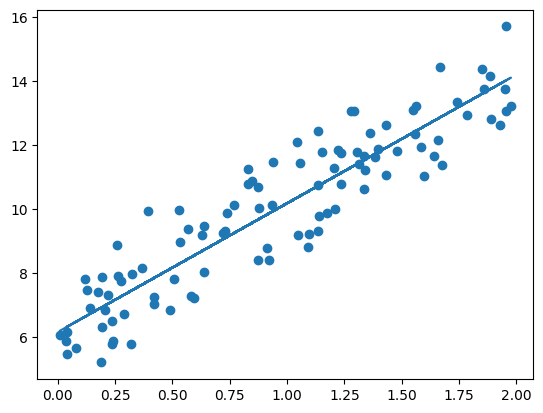

In [ ]:
plt.scatter(X, y)
plt.plot(X,y_pred)

미니 배치 확률적 경사 하강법을 이용한 최적 비용함수 도출

In [ ]:
def stochastic_gradient_descent_steps(X, y, batch_size=10, iters=1000):
    w0 = np.zeros((1,1))
    w1 = np.zeros((1,1))
    prev_cost = 100000
    iter_index =0

    for ind in range(iters):
        np.random.seed(ind)
        # 전체 X, y 데이터에서 랜덤하게 batch_size만큼 데이터 추출하여 sample_X, sample_y로 저장
        stochastic_random_index = np.random.permutation(X.shape[0])
        sample_X = X[stochastic_random_index[0:batch_size]]
        sample_y = y[stochastic_random_index[0:batch_size]]
        # 랜덤하게 batch_size만큼 추출된 데이터 기반으로 w1_update, w0_update 계산 후 업데이트
        w1_update, w0_update = get_weight_updates(w1, w0, sample_X, sample_y, learning_rate=0.01)
        w1 = w1 - w1_update
        w0 = w0 - w0_update

    return w1, w0

In [ ]:
w1, w0 = stochastic_gradient_descent_steps(X, y, iters=1000)
print("w1:",round(w1[0,0],3),"w0:",round(w0[0,0],3))
y_pred = w1[0,0] * X + w0
print('Stochastic Gradient Descent Total Cost:{0:.4f}'.format(get_cost(y, y_pred)))

w1: 4.028 w0: 6.156
Stochastic Gradient Descent Total Cost:0.9937


# Polynomial Regression

PolynomialFeatures 클래스로 다항식 변환

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

# 다항식으로 변환한 단항식 생성, [[0,1],[2,3]]의 2X2 행렬 생성
X = np.arange(4).reshape(2,2)
print('일차 단항식 계수 feature:\n',X )

# degree = 2 인 2차 다항식으로 변환하기 위해 PolynomialFeatures를 이용하여 변환
poly = PolynomialFeatures(degree=2)
poly.fit(X)
poly_ftr = poly.transform(X)
print('변환된 2차 다항식 계수 feature:\n', poly_ftr)

일차 단항식 계수 feature:
 [[0 1]
 [2 3]]
변환된 2차 다항식 계수 feature:
 [[1. 0. 1. 0. 0. 1.]
 [1. 2. 3. 4. 6. 9.]]


3차 다항식 결정값을 구하는 함수 polynomial_func(X) 생성. 즉 회귀식은 결정값 y = 1+ 2x_1 + 3x_1^2 + 4x_2^3

In [ ]:
def polynomial_func(X):
    y = 1 + 2*X[:,0] + 3*X[:,0]**2 + 4*X[:,1]**3
    print(X[:, 0])
    print(X[:, 1])
    return y

X = np.arange(0,4).reshape(2,2)

print('일차 단항식 계수 feature: \n' ,X)
y = polynomial_func(X)
print('삼차 다항식 결정값: \n', y)

일차 단항식 계수 feature: 
 [[0 1]
 [2 3]]
[0 2]
[1 3]
삼차 다항식 결정값: 
 [  5 125]


3차 다항식 계수의 피처값과 3차 다항식 결정값으로 학습

In [ ]:
from sklearn.linear_model import LinearRegression

# 3 차 다항식 변환
poly_ftr = PolynomialFeatures(degree=3).fit_transform(X)
print('3차 다항식 계수 feature: \n',poly_ftr)

# Linear Regression에 3차 다항식 계수 feature와 3차 다항식 결정값으로 학습 후 회귀 계수 확인
model = LinearRegression()
model.fit(poly_ftr,y)
print('Polynomial 회귀 계수\n' , np.round(model.coef_, 2))
print('Polynomial 회귀 Shape :', model.coef_.shape)

3차 다항식 계수 feature: 
 [[ 1.  0.  1.  0.  0.  1.  0.  0.  0.  1.]
 [ 1.  2.  3.  4.  6.  9.  8. 12. 18. 27.]]
Polynomial 회귀 계수
 [0.   0.18 0.18 0.36 0.54 0.72 0.72 1.08 1.62 2.34]
Polynomial 회귀 Shape : (10,)


## 다항 회귀를 이용한 과소적합 및 과적합 이해

cosine 곡선에 약간의 Noise 변동값을 더하여 실제값 곡선을 만듬

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
%matplotlib inline

# 임의의 값으로 구성된 X값에 대해 코사인 변환 값을 반환.
def true_fun(X):
    return np.cos(1.5 * np.pi * X)

# X는 0부터 1까지 30개의 임의의 값을 순서대로 샘플링한 데이터입니다.
np.random.seed(0)
n_samples = 30
X = np.sort(np.random.rand(n_samples))

# y 값은 코사인 기반의 true_fun()에서 약간의 노이즈 변동 값을 더한 값입니다.
y = true_fun(X) + np.random.randn(n_samples) * 0.1

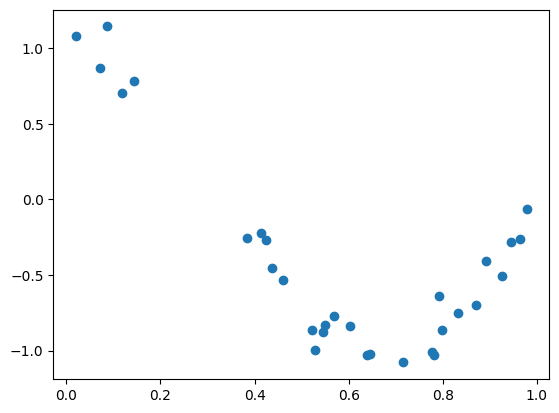

In [ ]:
plt.scatter(X, y)


Degree 1 회귀 계수는 [-1.61] 입니다.
Degree 1 MSE 는 0.4077289625098685 입니다.

Degree 4 회귀 계수는 [  0.47 -17.79  23.59  -7.26] 입니다.
Degree 4 MSE 는 0.04320874987232064 입니다.

Degree 15 회귀 계수는 [-2.98293000e+03  1.03899390e+05 -1.87416123e+06  2.03716219e+07
 -1.44873283e+08  7.09315363e+08 -2.47065792e+09  6.24561050e+09
 -1.15676510e+10  1.56894936e+10 -1.54006023e+10  1.06457264e+10
 -4.91377530e+09  1.35919645e+09 -1.70380786e+08] 입니다.
Degree 15 MSE 는 181238256.56423894 입니다.


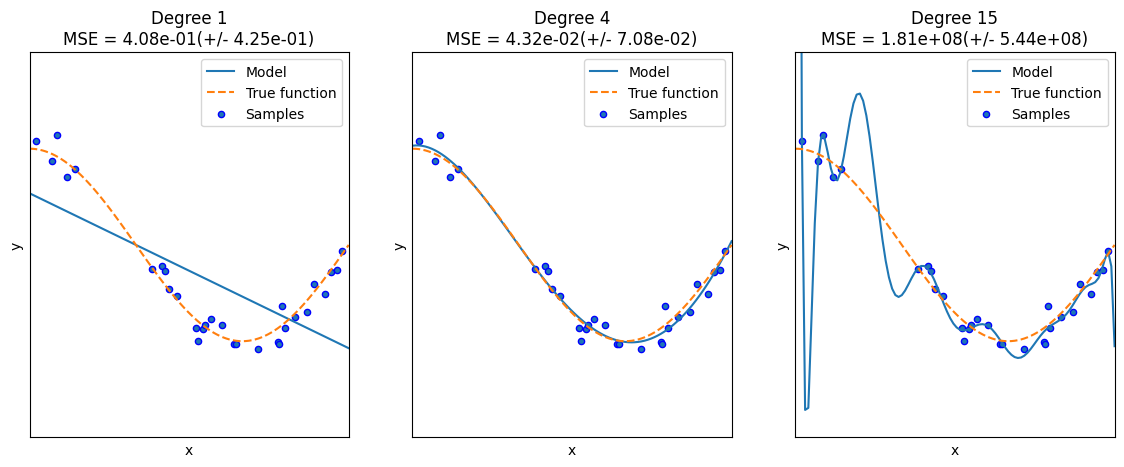

In [ ]:
plt.figure(figsize=(14, 5))
degrees = [1, 4, 15]

# 다항 회귀의 차수(degree)를 1, 4, 15로 각각 변화시키면서 비교합니다.
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    # 개별 degree별로 Polynomial 변환합니다.
    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X.reshape(-1, 1), y)

    # 교차 검증으로 다항 회귀를 평가합니다.
    scores = cross_val_score(pipeline, X.reshape(-1, 1), y, scoring="neg_mean_squared_error", cv=10)
    # Pipeline을 구성하는 세부 객체를 접근하는 named_steps['객체명']을 이용해 회귀계수 추출
    coefficients = pipeline.named_steps['linear_regression'].coef_
    print('\nDegree {0} 회귀 계수는 {1} 입니다.'.format(degrees[i], np.round(coefficients, 2)))
    print('Degree {0} MSE 는 {1} 입니다.'.format(degrees[i], -1*np.mean(scores)))

    # 0 부터 1까지 테스트 데이터 세트를 100개로 나눠 예측을 수행합니다.
    # 테스트 데이터 세트에 회귀 예측을 수행하고 예측 곡선과 실제 곡선을 그려서 비교합니다.
    X_test = np.linspace(0, 1, 100)
    # 예측값 곡선
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    # 실제 값 곡선
    plt.plot(X_test, true_fun(X_test), '--', label="True function")
    plt.scatter(X, y, edgecolor='b', s=20, label="Samples")
    plt.xlabel("x"); plt.ylabel("y"); plt.xlim((0, 1)); plt.ylim((-2, 2)); plt.legend(loc="best")
    plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(degrees[i], -scores.mean(), scores.std()))

plt.show()

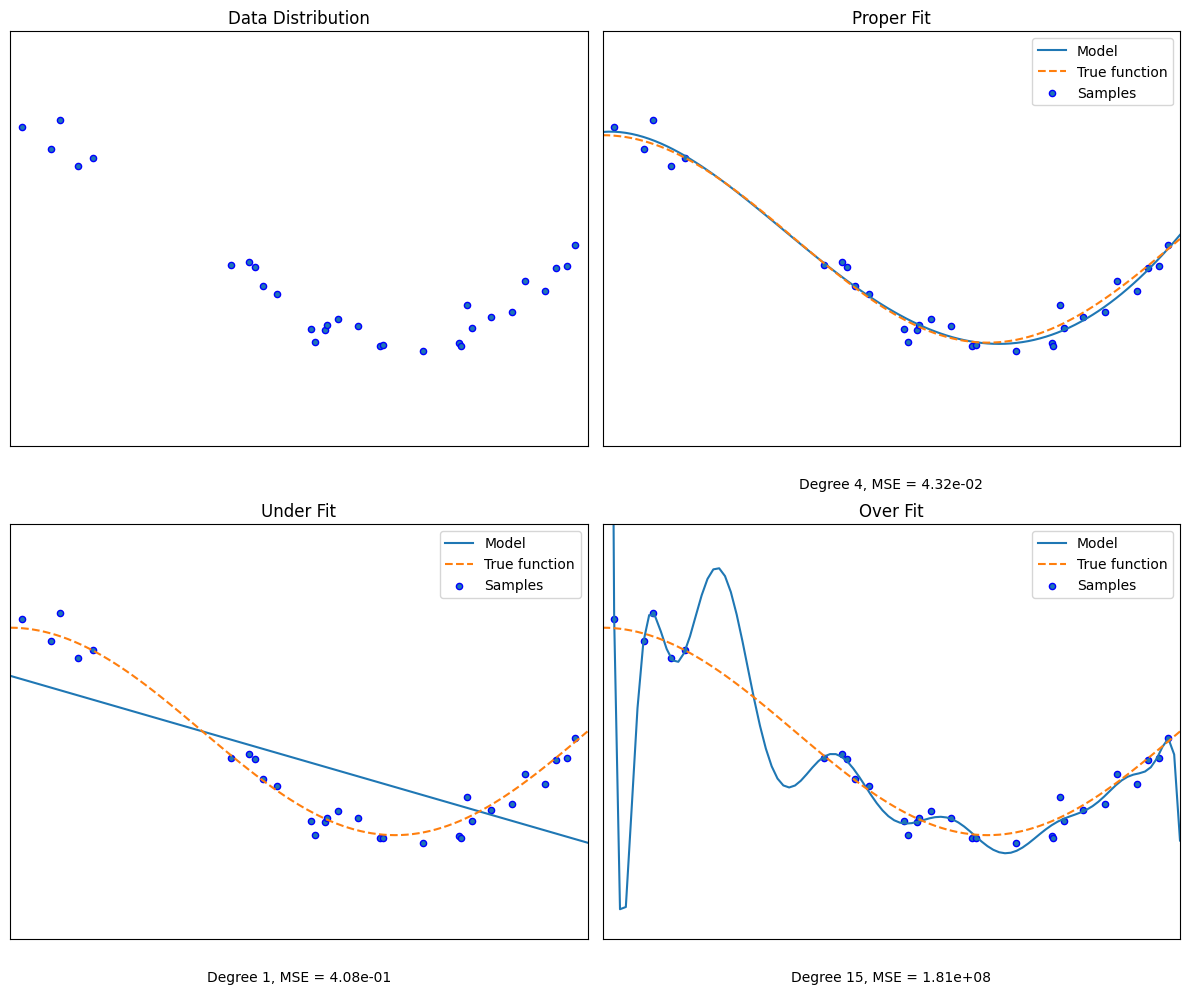

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

%matplotlib inline

def true_fun(X):
    return np.cos(1.5 * np.pi * X)

np.random.seed(0)
n_samples = 30
X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

fig = plt.figure(figsize=(12, 10))

# (1,1): 데이터 산점도만 표시 (label 없음, true function 없음)
ax1 = fig.add_subplot(2, 2, 1)
ax1.scatter(X, y, edgecolor='b', s=20)
ax1.set_xlim((0, 1)); ax1.set_ylim((-2, 2))
ax1.set_xticks([]); ax1.set_yticks([])
ax1.set_title("Data Distribution")
# 하단 텍스트 표시 없음 (degree, MSE가 없기 때문)

# 차수, 위치, 제목 설정
degrees = [4, 1, 15]
positions = [2, 3, 4]
titles = ["Proper Fit", "Under Fit", "Over Fit"]

for i in range(len(degrees)):
    ax = fig.add_subplot(2, 2, positions[i])
    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([
        ("polynomial_features", polynomial_features),
        ("linear_regression", linear_regression)
    ])
    pipeline.fit(X.reshape(-1, 1), y)

    scores = cross_val_score(pipeline, X.reshape(-1, 1), y,
                             scoring="neg_mean_squared_error", cv=10)

    X_test = np.linspace(0, 1, 100)
    ax.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    ax.plot(X_test, true_fun(X_test), '--', label="True function")
    ax.scatter(X, y, edgecolor='b', s=20, label="Samples")
    ax.set_xlim((0, 1)); ax.set_ylim((-2, 2))
    ax.set_xticks([]); ax.set_yticks([])

    ax.set_title(titles[i])

    # 그래프 하단에 degree와 MSE 표기 (x축 중앙에 위치)
    ax.text(0.5, -2.3,
            f"Degree {degrees[i]}, MSE = {-scores.mean():.2e}",
            ha='center', va='top', fontsize=10, transform=ax.transData)

    ax.legend(loc="best")

plt.tight_layout()
plt.show()


# Regularized Linear Models

## Regularized Linear Model - Ridge Regression

In [ ]:
# 앞의 LinearRegression예제에서 분할한 feature 데이터 셋인 X_data과 Target 데이터 셋인 Y_target 데이터셋을 그대로 이용
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

ridge = Ridge(alpha = 10)
neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
rmse_scores  = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)
print(' 5 folds 의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 3))
print(' 5 folds 의 개별 RMSE scores : ', np.round(rmse_scores,3))
print(' 5 folds 의 평균 RMSE : {0:.3f} '.format(avg_rmse))

 5 folds 의 개별 Negative MSE scores:  [-11.422 -24.294 -28.144 -74.599 -28.517]
 5 folds 의 개별 RMSE scores :  [3.38  4.929 5.305 8.637 5.34 ]
 5 folds 의 평균 RMSE : 5.518 


alpha값을 0 , 0.1 , 1 , 10 , 100 으로 변경하면서 RMSE 측정

In [ ]:
# 릿지에 사용될 alpha 파라미터의 값을 정의
alphas = [0, 0.1, 1, 10, 100]

# alphas list 값을 반복하면서 alpha에 따른 평균 rmse를 구함.
for alpha in alphas :
    ridge = Ridge(alpha = alpha)

    # cross_val_score를 이용해 5 폴드의 평균 RMSE를 계산
    neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
    avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
    print('alpha {0} 일 때 5 folds 의 평균 RMSE : {1:.3f} '.format(alpha, avg_rmse))

alpha 0 일 때 5 folds 의 평균 RMSE : 5.829 
alpha 0.1 일 때 5 folds 의 평균 RMSE : 5.788 
alpha 1 일 때 5 folds 의 평균 RMSE : 5.653 
alpha 10 일 때 5 folds 의 평균 RMSE : 5.518 
alpha 100 일 때 5 folds 의 평균 RMSE : 5.330 


각 alpha에 따른 회귀 계수 값을 시각화. 각 alpha값 별로 plt.subplots로 맷플롯립 축 생성

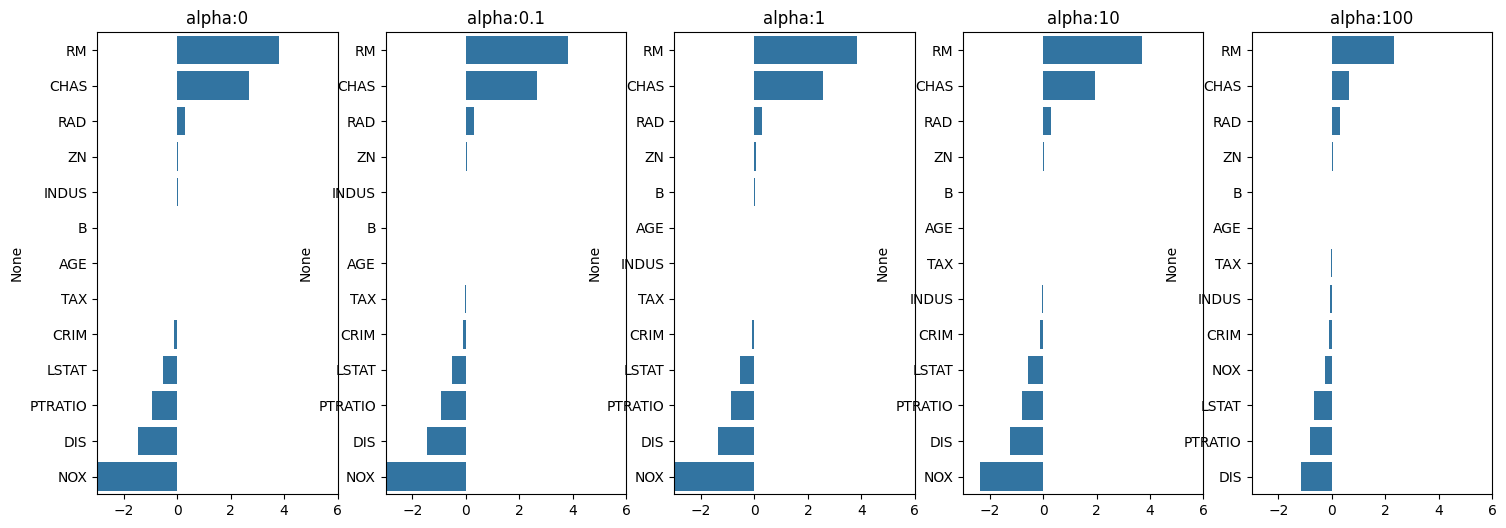

In [ ]:
import seaborn as sns

# 각 alpha에 따른 회귀 계수 값을 시각화하기 위해 5개의 열로 된 맷플롯립 축 생성
fig , axs = plt.subplots(figsize=(18,6) , nrows=1 , ncols=5)
# 각 alpha에 따른 회귀 계수 값을 데이터로 저장하기 위한 DataFrame 생성
coeff_df = pd.DataFrame()

# alphas 리스트 값을 차례로 입력해 회귀 계수 값 시각화 및 데이터 저장. pos는 axis의 위치 지정
for pos , alpha in enumerate(alphas) :
    ridge = Ridge(alpha = alpha)
    ridge.fit(X_data , y_target)
    # alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 컬럼으로 추가.
    coeff = pd.Series(data=ridge.coef_ , index=X_data.columns )
    colname='alpha:'+str(alpha)
    coeff_df[colname] = coeff
    # 막대 그래프로 각 alpha 값에서의 회귀 계수를 시각화. 회귀 계수값이 높은 순으로 표현
    coeff = coeff.sort_values(ascending=False)
    axs[pos].set_title(colname)
    axs[pos].set_xlim(-3,6)
    sns.barplot(x=coeff.values , y=coeff.index, ax=axs[pos])

# for 문 바깥에서 맷플롯립의 show 호출 및 alpha에 따른 피처별 회귀 계수를 DataFrame으로 표시
plt.show()

alpha 값에 따른 컬럼별 회귀계수 출력

In [ ]:
ridge_alphas = [0 , 0.1 , 1 , 10 , 100]
sort_column = 'alpha:'+str(ridge_alphas[0])
coeff_df.sort_values(by=sort_column, ascending=False)

,alpha:0,alpha:0.1,alpha:1,alpha:10,alpha:100
RM,3.809865,3.818233,3.854000,3.702272,2.334536
CHAS,2.686734,2.670019,2.552393,1.952021,0.638335
RAD,0.306049,0.303515,0.290142,0.279596,0.315358
ZN,0.046420,0.046572,0.047443,0.049579,0.054496
INDUS,0.020559,0.015999,-0.008805,-0.042962,-0.052826
B,0.009312,0.009368,0.009673,0.010037,0.009393
AGE,0.000692,-0.000269,-0.005415,-0.010707,0.001212
TAX,-0.012335,-0.012421,-0.012912,-0.013993,-0.015856
CRIM,-0.108011,-0.107474,-0.104595,-0.101435,-0.102202
LSTAT,-0.524758,-0.525966,-0.533343,-0.559366,-0.660764


## Lasso Regression

In [ ]:
# 라쏘에 사용될 alpha 파라미터의 값들을 정의하고 get_linear_reg_eval() 함수 호출
lasso_alphas = [ 0.07, 0.1, 0.5, 1, 3]
coeff_lasso_df =get_linear_reg_eval('Lasso', params=lasso_alphas, X_data_n=X_data, y_target_n=y_target)

#######  Lasso #######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 5.612 
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.615 
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 5.669 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.776 
alpha 3일 때 5 폴드 세트의 평균 RMSE: 6.189 


In [ ]:
# 반환된 coeff_lasso_df를 첫번째 컬럼순으로 내림차순 정렬하여 회귀계수 DataFrame출력
sort_column = 'alpha:'+str(lasso_alphas[0])
coeff_lasso_df.sort_values(by = sort_column, ascending = False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.789725,3.703202,2.498212,0.949811,0.000000
CHAS,1.434343,0.955190,0.000000,0.000000,0.000000
RAD,0.270936,0.274707,0.277451,0.264206,0.061864
ZN,0.049059,0.049211,0.049544,0.049165,0.037231
B,0.010248,0.010249,0.009469,0.008247,0.006510
NOX,-0.000000,-0.000000,-0.000000,-0.000000,0.000000
AGE,-0.011706,-0.010037,0.003604,0.020910,0.042495
TAX,-0.014290,-0.014570,-0.015442,-0.015212,-0.008602
INDUS,-0.042120,-0.036619,-0.005253,-0.000000,-0.000000
CRIM,-0.098193,-0.097894,-0.083289,-0.063437,-0.000000


## Elastic Net Regression



*   L1 규제 + L2 규제를 혼합한 형태의 정규화 회귀
*   Lasso의 특성 선택 효과 + Ridge의 안정성을 둘 다 가짐
*   특히, 변수가 많고 상관관계가 높은 경우에 효과적



In [ ]:
# 엘라스틱넷에 사용될 alpha 파라미터의 값들을 정의하고 get_linear_reg_eval() 함수 호출
# l1_ratio는 0.7로 고정
elastic_alphas = [ 0.07, 0.1, 0.5, 1, 3]
coeff_elastic_df =get_linear_reg_eval('ElasticNet', params=elastic_alphas,
                                      X_data_n=X_data, y_target_n=y_target)

#######  ElasticNet #######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 5.542 
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.526 
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 5.467 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.597 
alpha 3일 때 5 폴드 세트의 평균 RMSE: 6.068 


In [ ]:
# 반환된 coeff_elastic_df를 첫번째 컬럼순으로 내림차순 정렬하여 회귀계수 DataFrame출력
sort_column = 'alpha:'+str(elastic_alphas[0])
coeff_elastic_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.574162,3.414154,1.918419,0.938789,0.000000
CHAS,1.330724,0.979706,0.000000,0.000000,0.000000
RAD,0.278880,0.283443,0.300761,0.289299,0.146846
ZN,0.050107,0.050617,0.052878,0.052136,0.038268
B,0.010122,0.010067,0.009114,0.008320,0.007020
AGE,-0.010116,-0.008276,0.007760,0.020348,0.043446
TAX,-0.014522,-0.014814,-0.016046,-0.016218,-0.011417
INDUS,-0.044855,-0.042719,-0.023252,-0.000000,-0.000000
CRIM,-0.099468,-0.099213,-0.089070,-0.073577,-0.019058
NOX,-0.175072,-0.000000,-0.000000,-0.000000,-0.000000


# Logistic Regression

- 로지스틱 회귀: 선형 회귀 방식을 분류에 적용한 알고리즘
- 학습을 통해 회귀 최적선이 아닌 **시그모이드(Sigmoid) 함수** 최적선을 찾는다.
- 시그모이드 함수의 변환 값을 확률로 간주해 확률에 따른 분류를 결정한다.

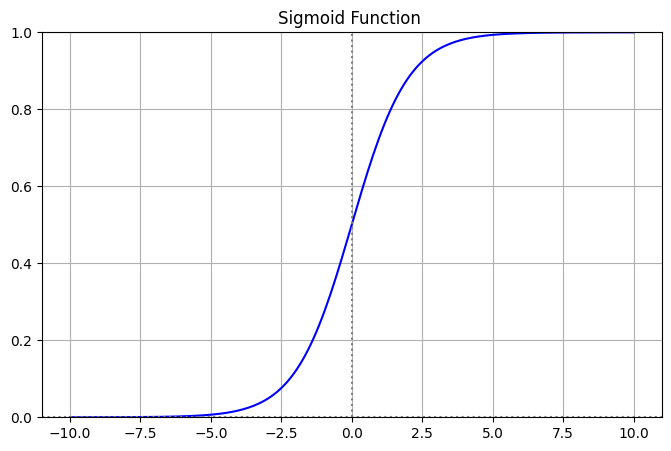

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 시그모이드 함수 정의
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# x 값 범위 설정
x = np.linspace(-10, 10, 200)
y_sigmoid = sigmoid(x)
y_linear = x  # 선형 함수

# x 값 범위 설정
x = np.linspace(-10, 10, 200)
y_sigmoid = sigmoid(x)
y_linear = x  # 선형 함수

# y축 범위를 -2에서 2로 제한하고 세로 비율 확장하여 그래프 다시 그리기
plt.figure(figsize=(8, 5))  # 세로 비율 확장
plt.plot(x, y_sigmoid,  color='blue')
plt.title('Sigmoid Function ')
plt.grid(True)
plt.axhline(0, color='gray', linestyle=':')
plt.axvline(0, color='gray', linestyle=':')
plt.ylim(0, 1)
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

cancer = load_breast_cancer()

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# StandardScaler( )로 평균이 0, 분산 1로 데이터 분포도 변환
scaler = StandardScaler()
data_scaled = scaler.fit_transform(cancer.data)

X_train , X_test, y_train , y_test = train_test_split(data_scaled, cancer.target, test_size=0.3, random_state=0)

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score

# 로지스틱 회귀를 이용하여 학습 및 예측 수행.
# solver인자값을 생성자로 입력하지 않으면 solver='lbfgs'
lr_clf = LogisticRegression() # solver='lbfgs'
lr_clf.fit(X_train, y_train)
lr_preds = lr_clf.predict(X_test)
lr_preds_proba = lr_clf.predict_proba(X_test)[:, 1]

# accuracy와 roc_auc 측정
print('accuracy: {0:.3f}, roc_auc:{1:.3f}'.format(accuracy_score(y_test, lr_preds),
                                                 roc_auc_score(y_test , lr_preds_proba)))

accuracy: 0.977, roc_auc:0.995


In [ ]:
solvers = ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']
# 여러개의 solver값 별로 LogisticRegression 학습 후 성능 평가
for solver in solvers:
    lr_clf = LogisticRegression(solver=solver, max_iter=600)
    lr_clf.fit(X_train, y_train)
    lr_preds = lr_clf.predict(X_test)
    lr_preds_proba = lr_clf.predict_proba(X_test)[:, 1]

    # accuracy와 roc_auc 측정
    print('solver:{0}, accuracy: {1:.3f}, roc_auc:{2:.3f}'.format(solver,
                                                                  accuracy_score(y_test, lr_preds),
                                                                  roc_auc_score(y_test , lr_preds_proba)))

solver:lbfgs, accuracy: 0.977, roc_auc:0.995
solver:liblinear, accuracy: 0.982, roc_auc:0.995
solver:newton-cg, accuracy: 0.977, roc_auc:0.995
solver:sag, accuracy: 0.982, roc_auc:0.995
solver:saga, accuracy: 0.982, roc_auc:0.995


In [ ]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

params={'solver':['liblinear', 'lbfgs'],
        'penalty':['l2', 'l1'],
        'C':[0.01, 0.1, 1, 5, 10]}

lr_clf = LogisticRegression()

grid_clf = GridSearchCV(lr_clf, param_grid=params, scoring='accuracy', cv=3 )
grid_clf.fit(data_scaled, cancer.target)
print('최적 하이퍼 파라미터:{0}, 최적 평균 정확도:{1:.3f}'.format(grid_clf.best_params_,
                                                  grid_clf.best_score_))

최적 하이퍼 파라미터:{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}, 최적 평균 정확도:0.979


# Regression Tree

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')  #사이킷런 1.2 부터는 보스턴 주택가격 데이터가 없어진다는 warning 메시지 출력 제거

rf = RandomForestRegressor(random_state=0, n_estimators=1000)
neg_mse_scores = cross_val_score(rf, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
rmse_scores  = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print(' 5 교차 검증의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 2))
print(' 5 교차 검증의 개별 RMSE scores : ', np.round(rmse_scores, 2))
print(' 5 교차 검증의 평균 RMSE : {0:.3f} '.format(avg_rmse))

 5 교차 검증의 개별 Negative MSE scores:  [ -7.88 -13.14 -20.57 -46.23 -18.88]
 5 교차 검증의 개별 RMSE scores :  [2.81 3.63 4.54 6.8  4.34]
 5 교차 검증의 평균 RMSE : 4.423 


In [ ]:
def get_model_cv_prediction(model, X_data, y_target):
    neg_mse_scores = cross_val_score(model, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
    rmse_scores  = np.sqrt(-1 * neg_mse_scores)
    avg_rmse = np.mean(rmse_scores)
    print('##### ',model.__class__.__name__ , ' #####')
    print(' 5 교차 검증의 평균 RMSE : {0:.3f} '.format(avg_rmse))

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

dt_reg = DecisionTreeRegressor(random_state=0, max_depth=4)
rf_reg = RandomForestRegressor(random_state=0, n_estimators=1000)
gb_reg = GradientBoostingRegressor(random_state=0, n_estimators=1000)
xgb_reg = XGBRegressor(n_estimators=1000)
lgb_reg = LGBMRegressor(n_estimators=1000,verbose=-1)

# 트리 기반의 회귀 모델을 반복하면서 평가 수행
models = [dt_reg, rf_reg, gb_reg, xgb_reg, lgb_reg]
for model in models:
    get_model_cv_prediction(model, X_data, y_target)

#####  DecisionTreeRegressor  #####
 5 교차 검증의 평균 RMSE : 5.978 
#####  RandomForestRegressor  #####
 5 교차 검증의 평균 RMSE : 4.423 
#####  GradientBoostingRegressor  #####
 5 교차 검증의 평균 RMSE : 4.269 
#####  XGBRegressor  #####
 5 교차 검증의 평균 RMSE : 4.959 
#####  LGBMRegressor  #####
 5 교차 검증의 평균 RMSE : 4.646 


<Axes: xlabel='None', ylabel='None'>

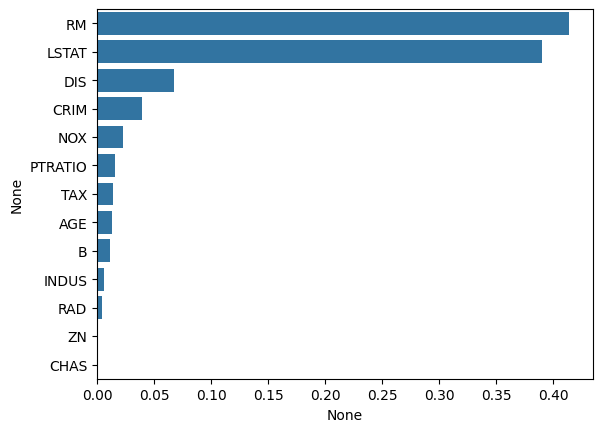

In [ ]:
import seaborn as sns
%matplotlib inline

rf_reg = RandomForestRegressor(n_estimators=1000)

# 앞 예제에서 만들어진 X_data, y_target 데이터 셋을 적용하여 학습합니다.
rf_reg.fit(X_data, y_target)

feature_series = pd.Series(data=rf_reg.feature_importances_, index=X_data.columns )
feature_series = feature_series.sort_values(ascending=False)
sns.barplot(x= feature_series, y=feature_series.index)

(100, 2)


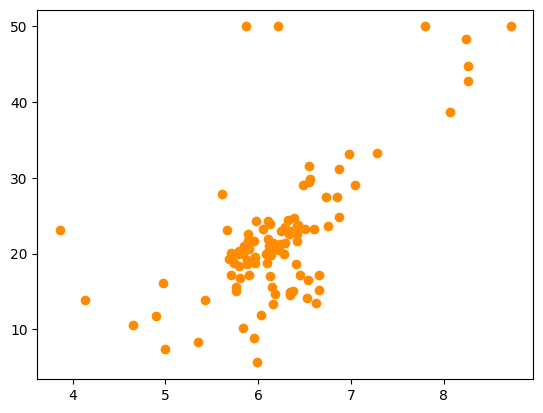

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

bostonDF_sample = bostonDF[['RM','PRICE']]
bostonDF_sample = bostonDF_sample.sample(n=100,random_state=0)
print(bostonDF_sample.shape)
plt.figure()
plt.scatter(bostonDF_sample.RM , bostonDF_sample.PRICE,c="darkorange")

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression

# 선형 회귀와 결정 트리 기반의 Regressor 생성. DecisionTreeRegressor의 max_depth는 각각 2, 7
lr_reg = LinearRegression()
rf_reg2 = DecisionTreeRegressor(max_depth=2)
rf_reg7 = DecisionTreeRegressor(max_depth=7)

# 실제 예측을 적용할 테스트용 데이터 셋을 4.5 ~ 8.5 까지 100개 데이터 셋 생성.
X_test = np.arange(4.5, 8.5, 0.04).reshape(-1, 1)

# 보스턴 주택가격 데이터에서 시각화를 위해 피처는 RM만, 그리고 결정 데이터인 PRICE 추출
X_feature = bostonDF_sample['RM'].values.reshape(-1,1)
y_target = bostonDF_sample['PRICE'].values.reshape(-1,1)

# 학습과 예측 수행.
lr_reg.fit(X_feature, y_target)
rf_reg2.fit(X_feature, y_target)
rf_reg7.fit(X_feature, y_target)

pred_lr = lr_reg.predict(X_test)
pred_rf2 = rf_reg2.predict(X_test)
pred_rf7 = rf_reg7.predict(X_test)

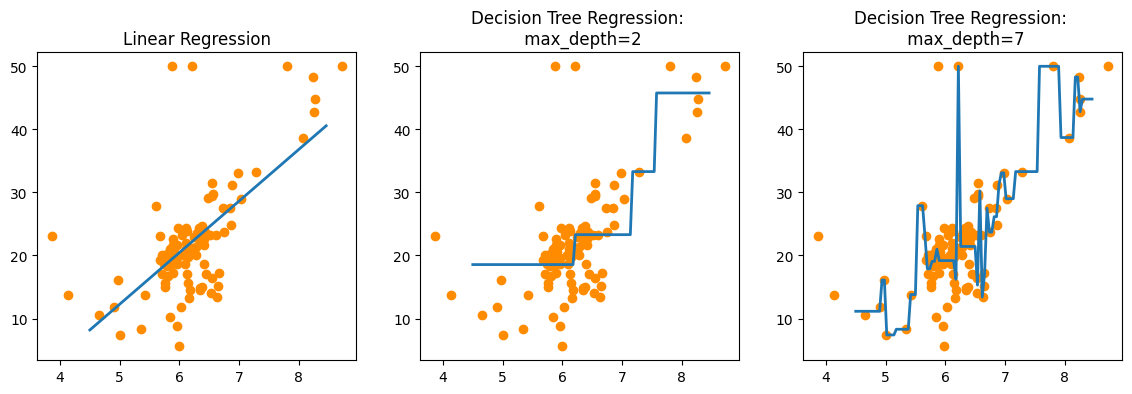

In [ ]:
fig , (ax1, ax2, ax3) = plt.subplots(figsize=(14,4), ncols=3)

# X축값을 4.5 ~ 8.5로 변환하며 입력했을 때, 선형 회귀와 결정 트리 회귀 예측 선 시각화
# 선형 회귀로 학습된 모델 회귀 예측선
ax1.set_title('Linear Regression')
ax1.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c="darkorange")
ax1.plot(X_test, pred_lr,label="linear", linewidth=2 )

# DecisionTreeRegressor의 max_depth를 2로 했을 때 회귀 예측선
ax2.set_title('Decision Tree Regression: \n max_depth=2')
ax2.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c="darkorange")
ax2.plot(X_test, pred_rf2, label="max_depth:3", linewidth=2 )

# DecisionTreeRegressor의 max_depth를 7로 했을 때 회귀 예측선
ax3.set_title('Decision Tree Regression: \n max_depth=7')
ax3.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c="darkorange")
ax3.plot(X_test, pred_rf7, label="max_depth:7", linewidth=2)

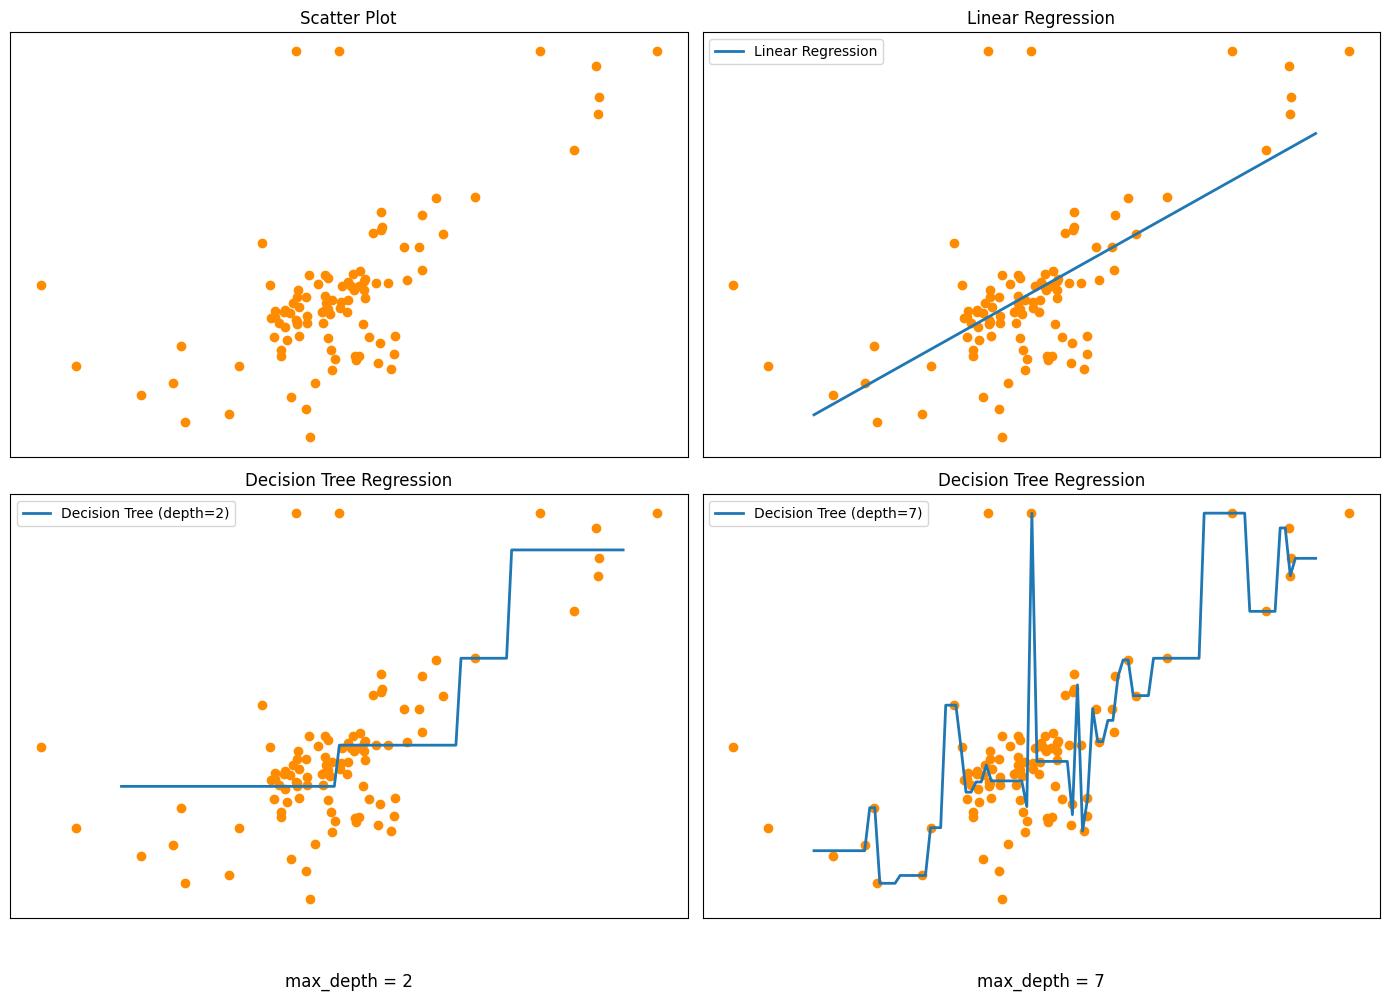

In [ ]:
# 2x2 subplot 생성
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# 1.1: 산점도
axs[0, 0].scatter(X_feature, y_target, c="darkorange")
axs[0, 0].set_title("Scatter Plot")
axs[0, 0].set_xticks([])
axs[0, 0].set_yticks([])

# 1.2: 선형 회귀
axs[0, 1].scatter(X_feature, y_target, c="darkorange")
axs[0, 1].plot(X_test, pred_lr, label="Linear Regression", linewidth=2)
axs[0, 1].set_title("Linear Regression")
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])
axs[0, 1].legend()

# 2.1: 회귀 트리 max_depth=2
axs[1, 0].scatter(X_feature, y_target, c="darkorange")
axs[1, 0].plot(X_test, pred_rf2, label="Decision Tree (depth=2)", linewidth=2)
axs[1, 0].set_title("Decision Tree Regression")
axs[1, 0].text(0.5, -0.15, 'max_depth = 2', ha='center', va='center', transform=axs[1,0].transAxes, fontsize=12)
axs[1, 0].set_xticks([])
axs[1, 0].set_yticks([])
axs[1, 0].legend()


# 2.2: 회귀 트리 max_depth=7
axs[1, 1].scatter(X_feature, y_target, c="darkorange")
axs[1, 1].plot(X_test, pred_rf7, label="Decision Tree (depth=7)", linewidth=2)
axs[1, 1].set_title("Decision Tree Regression")
axs[1,1].text(0.5, -0.15, 'max_depth = 7', ha='center', va='center', transform=axs[1,1].transAxes, fontsize=12)
axs[1, 1].set_xticks([])
axs[1, 1].set_yticks([])
axs[1, 1].legend()

plt.tight_layout()
plt.show()
